# Deep Learning for NLP - Project

RULES:

* Do not create any additional cell

* Fill in the blanks

* All cells should be runnable (modulo trivial compatibility bugs that we'd fix)

* 4 / 20 points will be allocated to the clarity of your code

* Efficient code will have a bonus

DELIVERABLE:

* this notebook
* the predictions of the SST test set

DO NOT INCLUDE THE DATASETS IN THE DELIVERABLE..

In [1]:
import io
import os
import numpy as np
import scipy

In [2]:
PATH_TO_DATA = "data/"

# 1) Monolingual (English) word embeddings 

In [3]:
class Word2vec():
    def __init__(self, fname, nmax=100000):
        self.load_wordvec(fname, nmax)
        self.word2id = dict.fromkeys(self.word2vec.keys())
        self.id2word = {v: k for k,v in self.word2id.items()}
        self.embeddings = np.array(self.word2vec.values())
        self.words = list(self.word2vec.keys())
    def load_wordvec(self, fname, nmax):
        self.word2vec = {}
        with io.open(fname, encoding='utf-8') as f:
            next(f)
            for i, line in enumerate(f):
                word, vec = line.split(' ', 1)
                self.word2vec[word] = np.fromstring(vec, sep=' ')
                if i == (nmax - 1):
                    break
        print('Loaded %s pretrained word vectors' % (len(self.word2vec)))

    def most_similar(self, w, K=5):
        # K most similar words: self.score  -  np.argsort 
        scores = np.array([])

        for wi in self.words:
            scores = np.append(scores,[self.score(wi,w)])
        scores_ind = np.argsort(scores)
        
        return ([self.words[i] for i in scores_ind[-K-1:-1]])

    def score(self, w1, w2):
        w1_em = self.word2vec[w1]
        w2_em = self.word2vec[w2]
        # cosine similarity: np.dot  -  np.linalg.norm
        
        return ((w1_em.dot(w2_em))/(np.linalg.norm(w1_em)*np.linalg.norm(w2_em)))


In [4]:
w2v = Word2vec('data/crawl-300d-200k.vec', nmax=200000)

# You will be evaluated on the output of the following:
for w1, w2 in zip(('cat', 'dog', 'dogs', 'paris', 'germany'), ('dog', 'pet', 'cats', 'france', 'berlin')):
    print(w1, w2, w2v.score(w1, w2))
for w1 in ['cat', 'dog', 'dogs', 'paris', 'germany']:
    print(w2v.most_similar(w1))

Loaded 200000 pretrained word vectors
cat dog 0.6716836662792491
dog pet 0.6842064029669219
dogs cats 0.7074389328052404
paris france 0.7775108541288561
germany berlin 0.7420295235998392
['kitties', 'feline', 'kitten', 'kitty', 'cats']
['canine', 'doggie', 'Dog', 'puppy', 'dogs']
['canines', 'doggies', 'Dogs', 'pooches', 'dog']
['berlin', 'london', 'parisian', 'Paris', 'france']
['poland', 'berlin', 'german', 'europe', 'austria']


In [5]:
class BoV():
    def __init__(self, w2v):
        self.w2v = w2v
    
    def encode(self, sentences, idf=False):
        # takes a list of sentences, outputs a numpy array of sentence embeddings
        # see TP1 for help
        sentemb = []
        for sent in sentences:
    
            sent  = sent.split(' ')
            s_em = np.zeros(300)
            if idf is False:
                # mean of word vectors
                n = len(sent)
                for i in range(n):
                    #s_em = np.add(s_em,w2v.word2vec[sent[i]])

                    if sent[i] in w2v.words:
                        s_em = np.add(s_em,w2v.word2vec[sent[i]])
            else:
                # idf-weighted mean of word vectors
                n = len(sent)
                for i in range(n):
                    #s_em = np.add(s_em,idf[sent[i]]*w2v.word2vec[sent[i]])
                    if sent[i] in w2v.words:
                        s_em += idf[sent[i]]*w2v.word2vec[sent[i]]
            s_em = (1./n)*s_em
            sentemb.append(s_em)                
        return np.vstack(sentemb)

    def most_similar(self, s, sentences, idf=False, K=5):
        # get most similar sentences and **print** them
        keys = self.encode(sentences, idf)
        query = self.encode([s], idf)
        scores = np.array([])
        n = keys.shape[0]
        print(n)

        for i in range(n):
            score = (query.dot(keys[i]))/(np.linalg.norm(query)*np.linalg.norm(keys[i]))
            #print(score)
            scores = np.append(scores,[score])
        
        scores_ind = np.argsort(scores)
        
        return ([sentences[i] for i in scores_ind[-K-1:-1]])

    def score(self, s1, s2, idf=False):
        # cosine similarity: use   np.dot  and  np.linalg.norm
        s_embs = self.encode([s1,s2],idf)
        s_e1 = s_embs[0,:]
        s_e2 = s_embs[1,:]
        return ((s_e1.dot(s_e2))/(np.linalg.norm(s_e1)*np.linalg.norm(s_e2)))
    
    def build_idf(self, sentences):
        # build the idf dictionary: associate each word to its idf value
        idf = {}
        for sent in sentences:
            sent  = sent.split(' ')
            for w in set(sent):
                idf[w] = idf.get(w, 0) + 1
        for w in list(idf.keys()):
            idf[w] = max(1, np.log10(len(sentences) / (idf[w])))
            
        # max(1, np.log10(len(sentences) / (idf[word])))
        return(idf)

In [6]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=20000)
s2v = BoV(w2v)


# Load sentences in "PATH_TO_DATA/sentences.txt"
text_file = open("data/sentences.txt",'r')
sentences = text_file.read().split('\n')

# Build idf scores for each word
idf = {} if True else s2v.build_idf(sentences)
# You will be evaluated on the output of the following:
print(s2v.most_similar('' if not sentences else sentences[10], sentences)) # BoV-mean
print(s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13]))

idf = s2v.build_idf(sentences)
print(s2v.most_similar('' if not sentences else sentences[10], sentences, idf) ) # BoV-idf
print(s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13], idf))





Loaded 20000 pretrained word vectors
150737


/Users/raphael/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide


['young boy on a motorcycle smiling . ', 'a small boy in goggles smiling . ', 'a little african american boy and girl looking up . ', 'an african american man smiling . ', '1 smiling african american boy . ']
0.5936035444177409
150737
['a little african american boy and girl looking up . ', '2 guys facing away from camera , 1 girl smiling at camera with blue shirt , 1 guy with a beverage with a jacket on . ', '5 women and 1 man are smiling for the camera . ', 'an african american man smiling . ', '1 smiling african american boy . ']
0.5004864201738877


# 2) Multilingual (English-French) word embeddings

Let's consider a bilingual dictionary of size V_a (e.g French-English).

Let's define **X** and **Y** the **French** and **English** matrices.

They contain the embeddings associated to the words in the bilingual dictionary.

We want to find a **mapping W** that will project the source word space (e.g French) to the target word space (e.g English).

Procrustes : **W\* = argmin || W.X - Y ||  s.t  W^T.W = Id**
has a closed form solution:
**W = U.V^T  where  U.Sig.V^T = SVD(Y.X^T)**

In what follows, you are asked to: 

In [7]:
# 1 - Download and load 50k first vectors of
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.vec
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.fr.vec

#!wget https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.vec
#!wget https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.fr.vec
En = {}
with open('wiki.en.vec') as f:
    for i in range(50001):
        line = f.readline()
        w = line.split(' ')
        if i>0:
            En[w[0]] = np.array([float(w[i])for i in range(1,301)])


Fr = {}
with open('wiki.fr.vec') as f:
    for i in range(50001):
        line = f.readline()
        w = line.split(' ')
        if i>0:
            Fr[w[0]] = np.array([float(w[i])for i in range(1,301)])


In [8]:
# 2 - Get words that appear in both vocabs (= identical character strings)
#     Use it to create the matrix X and Y (of aligned embeddings for these words)

voc_en = set(En.keys())
voc_fr = set(Fr.keys())

vocab = list(voc_en.intersection(voc_fr))

X = []
Y = []
for i in range(len(vocab)):
    X.append(En[vocab[i]])
    Y.append(Fr[vocab[i]])

X = np.array(X)
Y = np.array(Y)
    



In [9]:
# 3 - Solve the Procrustes using the scipy package and: scipy.linalg.svd() and get the optimal W
#     Now W*French_vector is in the same space as English_vector
from scipy import linalg
# TYPE CODE HERE
A = Y.T.dot(X)
U,S,Vt = scipy.linalg.svd(A)
W = U.dot(Vt)




In [10]:
# 4 - After alignment with W, give examples of English nearest neighbors of some French words (and vice versa)
#     You will be evaluated on that part and the code above
import operator
# TYPE CODE HERE

voc_fr
w1='peinte'
w2= 'treize'
w3 = 'laïque'
w4 = 'créées'
w5 =  'barbu'
w6 = 'nordiques'

def nearest_neighbors(w):
    neighbors = {}
    for word_en in voc_en:
        neighbors[word_en] = np.linalg.norm(W.dot(En[word_en]) - Fr[w])
    sorted_neighbors = sorted(neighbors.items(), key=operator.itemgetter(1))
    return(sorted_neighbors[0])

print('The closest word to '+w1+' is : '+ nearest_neighbors(w1)[0])
print('The closest word to '+w2+' is : '+ nearest_neighbors(w2)[0])
print('The closest word to '+w3+' is : '+ nearest_neighbors(w3)[0])
print('The closest word to '+w4+' is : '+ nearest_neighbors(w4)[0])
print('The closest word to '+w5+' is : '+ nearest_neighbors(w5)[0])
print('The closest word to '+w6+' is : '+ nearest_neighbors(w6)[0])


The closest word to peinte is : painted
The closest word to treize is : eleven
The closest word to laïque is : secular
The closest word to créées is : created
The closest word to barbu is : bearded
The closest word to nordiques is : scandinavian


If you want to dive deeper on this subject: https://github.com/facebookresearch/MUSE

# 3) Sentence classification with BoV and scikit-learn

In [11]:
# 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)

## LOADING VAL DATA
with open('data/SST/stsa.fine.dev') as f:
    lines = f.readlines()
n = len(lines)
X = []
Y = []
for i in range(n):
    Y.append(int(lines[i][0]))
    l_i = len(lines[i])
    X.append(lines[i][2:l_i-1])
X_val = np.array(X)
Y_val = np.array(Y)


## LOADING TRAIN DATA
with open('data/SST/stsa.fine.train') as f:
    lines = f.readlines()
n = len(lines)
X = []
Y = []
for i in range(n):
    Y.append(int(lines[i][0]))
    l_i = len(lines[i])
    X.append(lines[i][2:l_i-1])
X_train = np.array(X)
Y_train = np.array(Y)



## LOADING TEST DATA
with open('data/SST/stsa.fine.test.X') as f:
    lines = f.readlines()
l = []
for line in lines:
    line = line.split('\n')
    l.append(line[0])
X_test = np.array(l)

    

In [12]:
# 2 - Encode sentences with the BoV model above


X_train_emb = s2v.encode(X_train)
X_test_emb = s2v.encode(X_test)
X_val_emb = s2v.encode(X_val)

idf = s2v.build_idf(X_train)
X_train_emb_idf = s2v.encode(X_train,idf)

idf = s2v.build_idf(X_test)
X_test_emb_idf = s2v.encode(X_test,idf)

idf = s2v.build_idf(X_val)
X_val_emb_idf = s2v.encode(X_val,idf)

In [13]:
# 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
#     (consider tuning the L2 regularization on the dev set)
from sklearn.linear_model import LogisticRegression
C = [0.4]
for c in C :
    clf1 = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial',C = c).fit(X_train_emb, Y_train)
    print(str(c)+ " : " +str(clf1.score(X_val_emb, Y_val)))
print(str(c)+ " : " +str(clf1.score(X_train_emb, Y_train)))
C = [0.75]
for c in C :
    clf2 = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial',C = c).fit(X_train_emb_idf, Y_train)
    print(str(c)+ " : " +str(clf2.score(X_val_emb, Y_val)))
print(str(c)+ " : " +str(clf1.score(X_train_emb_idf, Y_train)))



0.4 : 0.4187102633969119
0.4 : 0.45271535580524347
0.75 : 0.38782924613987285
0.75 : 0.44417134831460675


In [14]:
# 4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).
#     Attach the output file "logreg_bov_y_test_sst.txt" to your deliverable.
#     You will be evaluated on the results of the test set.

# TYPE CODE HERE
Y1 = clf1.predict(X_test_emb)
Y2 = clf2.predict(X_test_emb_idf)

file = open('logreg_bov_y_test_sst.txt','w') 
for i in range (Y1.shape[0]):
    file.write(str(Y1[i])+ '\n') 
file.close() 


In [15]:
# BONUS!
# 5 - Try to improve performance with another classifier
#     Attach the output file "XXX_bov_y_test_sst.txt" to your deliverable (where XXX = the name of the classifier)


# 4) Sentence classification with LSTMs in Keras

## 4.1 - Preprocessing

In [16]:
import keras

/Users/raphael/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [17]:
# 1 - Load train/dev/test sets of SST
from keras.utils import np_utils
## LOADING VAL DATA
with open('data/SST/stsa.fine.dev') as f:
    lines = f.readlines()
n = len(lines)
X = []
Y = []
for i in range(n):
    Y.append(int(lines[i][0]))
    l_i = len(lines[i])
    X.append(lines[i][2:l_i-1])
X_val = np.array(X)
Y_val = np.array(Y)
Y_val = np_utils.to_categorical(Y_val)

## LOADING TRAIN DATA
with open('data/SST/stsa.fine.train') as f:
    lines = f.readlines()
n = len(lines)
X = []
Y = []
for i in range(n):
    Y.append(int(lines[i][0]))
    l_i = len(lines[i])
    X.append(lines[i][2:l_i-1])
X_train = np.array(X)
Y_train = np.array(Y)
Y_train = np_utils.to_categorical(Y_train)


## LOADING TEST DATA
with open('data/SST/stsa.fine.test.X') as f:
    lines = f.readlines()
l = []
for line in lines:
    line = line.split('\n')
    l.append(line[0])
X_test = np.array(l)
#Y_val = np_utils.to_categorical(Y_val)

In [18]:
# 2 - Transform text to integers using keras.preprocessing.text.one_hot function
#     https://keras.io/preprocessing/text/

train_sentences = list(X_train)
dev_sentences = list(X_val)
test_sentences = list(X_test)

from keras.preprocessing.text import one_hot
train = []
dev = []
test = []
for sent in train_sentences:
    train.append(one_hot(sent, 20000))
for sent in dev_sentences:
    dev.append(one_hot(sent, 20000))
for sent in test_sentences:
    test.append(one_hot(sent, 20000))



**Padding input data**

Models in Keras (and elsewhere) take batches of sentences of the same length as input. It is because Deep Learning framework have been designed to handle well Tensors, which are particularly suited for fast computation on the GPU.

Since sentences have different sizes, we "pad" them. That is, we add dummy "padding" tokens so that they all have the same length.

The input to a Keras model thus has this size : (batchsize, maxseqlen) where maxseqlen is the maximum length of a sentence in the batch.

In [19]:
# 3 - Pad your sequences using keras.preprocessing.sequence.pad_sequences
#     https://keras.io/preprocessing/sequence/
test = keras.preprocessing.sequence.pad_sequences(test,padding='pre', truncating='pre')
dev = keras.preprocessing.sequence.pad_sequences(dev,padding='pre', truncating='pre')
train = keras.preprocessing.sequence.pad_sequences(train,padding='pre', truncating='pre')


## 4.2 - Design and train your model

In [20]:
# 4 - Design your encoder + classifier using keras.layers
#     In Keras, Torch and other deep learning framework, we create a "container" which is the Sequential() module.
#     Then we add components to this contained : the lookuptable, the LSTM, the classifier etc.
#     All of these components are contained in the Sequential() and are trained together.


# ADAPT CODE BELOW


from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Activation

embed_dim  = 32  # word embedding dimension
nhid       = 64  # number of hidden units in the LSTM
vocab_size = 20000  # size of the vocabulary
n_classes  = 5

model = Sequential()
model.add(Embedding(vocab_size, embed_dim))
model.add(LSTM(nhid, dropout_W=0.5, dropout_U=0.5))
model.add(Dense(n_classes, activation='softmax'))


/Users/raphael/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, dropout=0.5, recurrent_dropout=0.5)`


In [21]:
# 5 - Define your loss/optimizer/metrics

# MODIFY CODE BELOW

loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          640000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 325       
Total params: 665,157
Trainable params: 665,157
Non-trainable params: 0
_________________________________________________________________
None


In [22]:
# 6 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set

# ADAPT CODE BELOW
bs = 32
n_epochs = 4


history = model.fit(train, Y_train, batch_size=bs, nb_epoch=n_epochs, validation_data=(dev, Y_val))

/Users/raphael/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  if __name__ == '__main__':


Train on 8544 samples, validate on 1101 samples
Epoch 1/4
8544/8544 [==============================] - 31s 4ms/step - loss: 1.5710 - acc: 0.2830 - val_loss: 1.5581 - val_acc: 0.3351
Epoch 2/4
8544/8544 [==============================] - 25s 3ms/step - loss: 1.4665 - acc: 0.3687 - val_loss: 1.4418 - val_acc: 0.3633
Epoch 3/4
8544/8544 [==============================] - 21s 2ms/step - loss: 1.2471 - acc: 0.4707 - val_loss: 1.4334 - val_acc: 0.3778
Epoch 4/4
8544/8544 [==============================] - 21s 2ms/step - loss: 1.0468 - acc: 0.5829 - val_loss: 1.4789 - val_acc: 0.3787


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


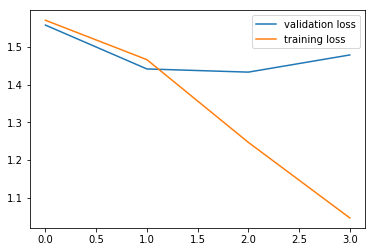

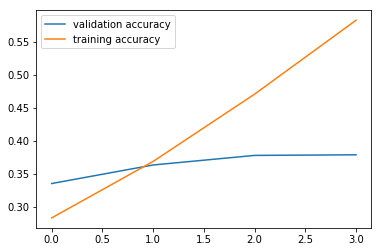

In [23]:
import matplotlib.pyplot as plt
#plt.plot(history)
print(history.history.keys())
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.plot(history.history['loss'], label = 'training loss')
plt.legend()
plt.show()

plt.plot(history.history['val_acc'], label = 'validation accuracy')
plt.plot(history.history['acc'], label = 'training accuracy')
plt.legend()
plt.show()

In [24]:
# 7 - Generate your predictions on the test set using model.predict(x_test)
#     https://keras.io/models/model/
#     Log your predictions in a file (one line = one integer: 0,1,2,3,4)
#     Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.

Y_lstm = model.predict(test)

file = open('logreg_lstm_y_test_sst.txt','w') 
for i in range (Y_lstm.shape[0]):
    file.write(str(np.argmax(Y_lstm[i]))+ '\n') 
file.close() 

## 4.3 -- innovate !

In [25]:
# 8 - Open question: find a model that is better on your dev set
#     (e.g: use a 1D ConvNet, use a better classifier, pretrain your lookup tables ..)
#     you will get point if the results on the test set are better: be careful of not overfitting your dev set too much..
#     Attach the output file "XXX_XXX_y_test_sst.txt" to your deliverable.

